In [1]:
!pip install tensorflow opencv-python numpy matplotlib

  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1


In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
import uuid

In [ ]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcamq
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [7]:
dir_test = anchor.as_numpy_iterator()

In [8]:
print(dir_test.next())

b'data\\anchor\\c45ff7a6-1ccc-11ee-b0ba-744ca1a24fd4.jpg'


In [9]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [10]:
img = preprocess('data\\anchor\\c5f816d3-1ccc-11ee-8e70-744ca1a24fd4.jpg')

In [11]:
img.numpy().max()

0.93235296

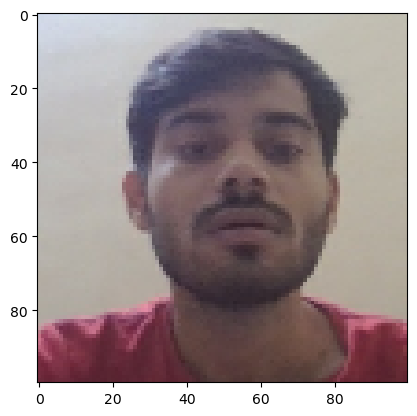

In [12]:
plt.imshow(img)

In [13]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [14]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [15]:
samples = data.as_numpy_iterator()

In [16]:
samples.next()

(b'data\\anchor\\ae9f2c4f-1ccc-11ee-aa95-744ca1a24fd4.jpg',
 b'data\\positive\\131b23eb-1ccd-11ee-85b2-744ca1a24fd4.jpg',
 1.0)

In [17]:
exampple = samples.next()

In [18]:
exampple

(b'data\\anchor\\c86e8492-1ccc-11ee-b404-744ca1a24fd4.jpg',
 b'data\\positive\\0eff59ea-1ccd-11ee-9861-744ca1a24fd4.jpg',
 1.0)

In [19]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
res = preprocess_twin(*exampple)

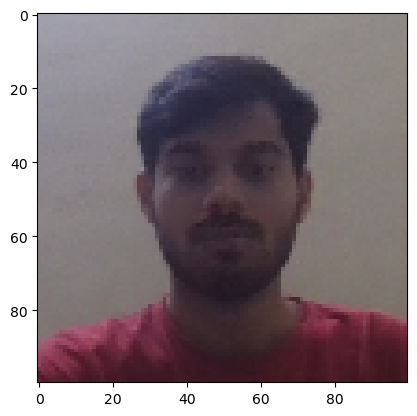

In [21]:
plt.imshow(res[1])

In [22]:
res[2]

1.0

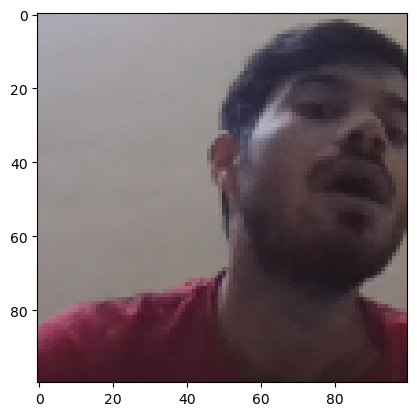

In [23]:
plt.imshow(res[0])

In [24]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [25]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [26]:
samples = data.as_numpy_iterator()

In [38]:
len(samples.next())

3

In [56]:
sam = samples.next()

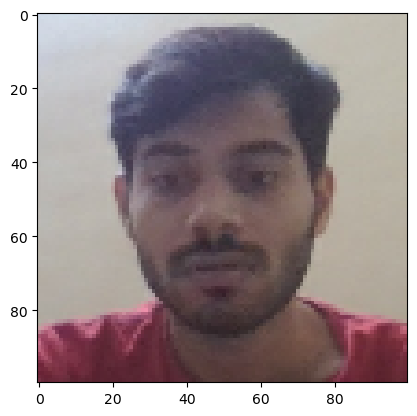

In [57]:
plt.imshow(sam[0])

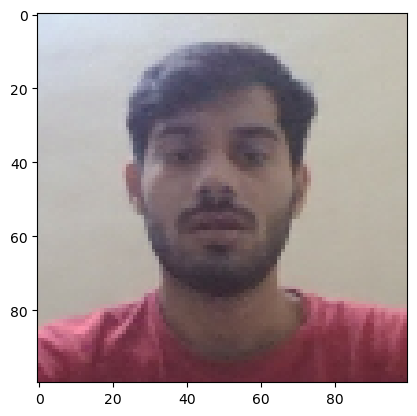

In [58]:
plt.imshow(sam[1])

In [59]:
sam[2]

1.0

In [64]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [65]:
train_samples = train_data.as_numpy_iterator()

In [78]:
train_sample = train_samples.next()

In [79]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [86]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [87]:
embedding = make_embedding()

In [88]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 128)       26

In [89]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [90]:
l1 = L1Dist()

In [92]:
l1

In [93]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [94]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [95]:
siamese_layer = L1Dist()

In [98]:
distances = siamese_layer(inp_embedding, val_embedding)

In [99]:
classifier = Dense(1, activation='sigmoid')(distances)

In [100]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_3')>

In [101]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [102]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [103]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [107]:
siamese_model = make_siamese_model()

In [108]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [109]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [110]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [111]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [112]:
test_batch = train_data.as_numpy_iterator()

In [113]:
batch_1 = test_batch.next()

In [114]:
X = batch_1[:2]

In [115]:
y = batch_1[2]

In [116]:
y

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

In [123]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [124]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [125]:
EPOCHS = 50

In [126]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 476s 18s/step

 Epoch 2/50
27/27 [==============================] - 1390s 53s/step

 Epoch 3/50
27/27 [==============================] - 443s 16s/step

 Epoch 4/50
27/27 [==============================] - 469s 17s/step

 Epoch 5/50
27/27 [==============================] - 469s 17s/step

 Epoch 6/50
27/27 [==============================] - 474s 17s/step

 Epoch 7/50
27/27 [==============================] - 487s 18s/step

 Epoch 8/50
27/27 [==============================] - 472s 18s/step

 Epoch 9/50
27/27 [==============================] - 484s 18s/step

 Epoch 10/50
27/27 [==============================] - 563s 21s/step

 Epoch 11/50
27/27 [==============================] - 610s 23s/step

 Epoch 12/50
27/27 [==============================] - 631s 23s/step

 Epoch 13/50
27/27 [=====

In [127]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [130]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [131]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[1.4005916e-08],
       [1.1761892e-06],
       [9.9991947e-01],
       [4.3627156e-07],
       [2.9754380e-11],
       [4.3486075e-06],
       [1.0000000e+00],
       [9.9843723e-01],
       [8.0500735e-09],
       [9.9999946e-01],
       [9.9987561e-01],
       [9.9093598e-01],
       [5.0197508e-07],
       [9.9999565e-01],
       [9.9999577e-01],
       [8.6418678e-10]], dtype=float32)

In [132]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0]

In [133]:
y_true

array([0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0.],
      dtype=float32)

In [134]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [135]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

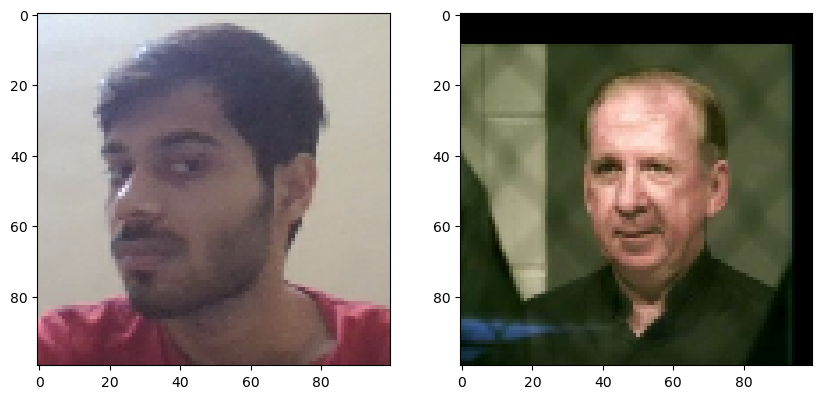

In [138]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

In [139]:
siamese_model.save('siamesemodel.h5')

In [140]:
L1Dist

__main__.L1Dist

In [141]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [142]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[1.4005916e-08],
       [1.1761892e-06],
       [9.9991947e-01],
       [4.3627156e-07],
       [2.9754380e-11],
       [4.3486075e-06],
       [1.0000000e+00],
       [9.9843723e-01],
       [8.0500735e-09],
       [9.9999946e-01],
       [9.9987561e-01],
       [9.9093598e-01],
       [5.0197508e-07],
       [9.9999565e-01],
       [9.9999577e-01],
       [8.6418678e-10]], dtype=float32)

In [143]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [147]:
os.listdir(os.path.join('application_data', 'verification_images'))

['003af5d5-1ccd-11ee-9baf-744ca1a24fd4.jpg',
 '0075a89b-1ccd-11ee-bcf3-744ca1a24fd4.jpg',
 '0094d4c2-1ccd-11ee-b6b7-744ca1a24fd4.jpg',
 '014adfd4-1ccd-11ee-b311-744ca1a24fd4.jpg',
 '015df34c-1ccd-11ee-87bb-744ca1a24fd4.jpg',
 '01871c41-1ccd-11ee-88b6-744ca1a24fd4.jpg',
 '02b9c361-1ccd-11ee-b18e-744ca1a24fd4.jpg',
 '03f2d0c8-1ccd-11ee-8c22-744ca1a24fd4.jpg',
 '05a1d967-1ccd-11ee-8141-744ca1a24fd4.jpg',
 '086fde3d-1ccd-11ee-98e1-744ca1a24fd4.jpg',
 '092a6fd1-1ccd-11ee-bcfe-744ca1a24fd4.jpg',
 '099c839d-1ccd-11ee-80ba-744ca1a24fd4.jpg',
 '0fc9bdcf-1ccd-11ee-82a5-744ca1a24fd4.jpg',
 '107eea7c-1ccd-11ee-bf31-744ca1a24fd4.jpg',
 '112e6c4f-1ccd-11ee-80e5-744ca1a24fd4.jpg',
 '119da509-1ccd-11ee-af89-744ca1a24fd4.jpg',
 '13bcc458-1ccd-11ee-a519-744ca1a24fd4.jpg',
 '13d6f891-1ccd-11ee-9636-744ca1a24fd4.jpg',
 '1486dc26-1ccd-11ee-8071-744ca1a24fd4.jpg',
 '14a5c532-1ccd-11ee-ab04-744ca1a24fd4.jpg',
 '14aef305-1ccd-11ee-a29a-744ca1a24fd4.jpg',
 '14bd676a-1ccd-11ee-afee-744ca1a24fd4.jpg',
 '14cdc89f

In [148]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [149]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\003af5d5-1ccd-11ee-9baf-744ca1a24fd4.jpg
application_data\verification_images\0075a89b-1ccd-11ee-bcf3-744ca1a24fd4.jpg
application_data\verification_images\0094d4c2-1ccd-11ee-b6b7-744ca1a24fd4.jpg
application_data\verification_images\014adfd4-1ccd-11ee-b311-744ca1a24fd4.jpg
application_data\verification_images\015df34c-1ccd-11ee-87bb-744ca1a24fd4.jpg
application_data\verification_images\01871c41-1ccd-11ee-88b6-744ca1a24fd4.jpg
application_data\verification_images\02b9c361-1ccd-11ee-b18e-744ca1a24fd4.jpg
application_data\verification_images\03f2d0c8-1ccd-11ee-8c22-744ca1a24fd4.jpg
application_data\verification_images\05a1d967-1ccd-11ee-8141-744ca1a24fd4.jpg
application_data\verification_images\086fde3d-1ccd-11ee-98e1-744ca1a24fd4.jpg
application_data\verification_images\092a6fd1-1ccd-11ee-bcfe-744ca1a24fd4.jpg
application_data\verification_images\099c839d-1ccd-11ee-80ba-744ca1a24fd4.jpg
application_data\verification_images\0fc9bdcf-1ccd-11ee-82a5-744

In [150]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [153]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 295ms/step
True
1/1 [==============================] - 0s 250ms/step
False
1/1 [==============================] - 0s 281ms/step
True
1/1 [==============================] - 0s 222ms/step


1/1 [==============================] - 0s 263ms/step
False
1/1 [==============================] - 0s 337ms/step
False
1/1 [==============================] - 0s 306ms/step
False
1/1 [==============================] - 0s 496ms/step


1/1 [==============================] - 1s 511ms/step
False
1/1 [==============================] - 0s 493ms/step
True
1/1 [==============================] - 0s 459ms/step
True
1/1 [==============================] - 0s 483ms/step


1/1 [==============================] - 0s 468ms/step
False
1/1 [==============================] - 1s 513ms/step
True
1/1 [==============================] - 0s 474ms/step
False
1/1 [==============================] - 0s 440ms/step


1/1 [==============================] - 0s 473ms/step
True
1/1 [==============================] - 0s 457ms/step
True


In [154]:
results

[array([[0.84629834]], dtype=float32),
 array([[0.00023422]], dtype=float32),
 array([[0.00102815]], dtype=float32),
 array([[0.99876136]], dtype=float32),
 array([[0.35780928]], dtype=float32),
 array([[0.24794321]], dtype=float32),
 array([[0.3159507]], dtype=float32),
 array([[0.99997896]], dtype=float32),
 array([[0.02493313]], dtype=float32),
 array([[0.02569786]], dtype=float32),
 array([[0.01087736]], dtype=float32),
 array([[0.83051074]], dtype=float32),
 array([[0.9998501]], dtype=float32),
 array([[0.9999997]], dtype=float32),
 array([[0.9999998]], dtype=float32),
 array([[0.9997183]], dtype=float32),
 array([[0.9999995]], dtype=float32),
 array([[0.9999999]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.9999999]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.9999991]], dtype=float32),
 array([[0.99999934]], dtype=float32),
 array([[0.99999964]], dtype=float

In [162]:
(np.squeeze(results) > 0.5)

array([ True, False, False,  True, False, False, False,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])